In [7]:
# ===========================
# Task 4: Predictive Modeling & Risk Scoring
# ===========================

# ===========================
# Step 0: Import Libraries
# ===========================
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# Optional: display all columns
pd.set_option('display.max_columns', None)

# ===========================
# Step 1: Load Data
# ===========================
data_path = os.path.join('..', 'data', 'insurance_data.csv')  # '..' goes one folder up
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found at {data_path}. Please check your path!")

df = pd.read_csv(data_path)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# ===========================
# Step 2: Define Targets
# ===========================
# Claim Frequency (binary)
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)

# Claim Severity (continuous, fill 0 if no claim)
df['ClaimSeverity'] = df['TotalClaims'] / df['ClaimFrequency'].replace(0, np.nan)
df['ClaimSeverity'].fillna(0, inplace=True)

# ===========================
# Step 3: Feature Selection
# ===========================
features = ['TotalPremium', 'Age', 'Gender', 'Province']  # adjust based on dataset
target_class = 'ClaimFrequency'
target_reg = 'ClaimSeverity'

# Drop missing values
df = df.dropna(subset=features + [target_class, target_reg])

# ===========================
# Step 4: Preprocessing Pipeline
# ===========================
categorical_features = ['Gender', 'Province']
numerical_features = ['TotalPremium', 'Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# ===========================
# Step 5: Train-Test Split
# ===========================
X = df[features]
y_class = df[target_class]
y_reg = df[target_reg]

# Classification split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Regression split
X_train_r, X_test_r, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# ===========================
# Step 6a: Classification Model
# ===========================
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

# Evaluation
print("=== Classification: Claim Frequency ===")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))

# ===========================
# Step 6b: Regression Model
# ===========================
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

reg.fit(X_train_r, y_train_reg)
y_pred_reg = reg.predict(X_test_r)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("\n=== Regression: Claim Severity ===")
print("RMSE:", rmse)

# ===========================
# Step 7: Feature Importance (Classification)
# ===========================
feature_names = numerical_features + list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importances = clf.named_steps['classifier'].feature_importances_

feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
display(feat_importance)

# ===========================
# Step 8: Save Predictions
# ===========================
df_pred = X_test.copy()
df_pred['Pred_ClaimFrequency'] = y_pred_class
df_pred['Pred_ClaimSeverity'] = y_pred_reg

results_path = os.path.join('..', 'results', 'task4_predictions.csv')
os.makedirs(os.path.dirname(results_path), exist_ok=True)
df_pred.to_csv(results_path, index=False)
print(f"\nPredictions saved to {results_path}")


Columns in dataset: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60


=== Classification: Claim Frequency ===
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_22520\4293864904.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ClaimSeverity'].fillna(0, inplace=True)



=== Regression: Claim Severity ===
RMSE: 3253.745952283425

Feature Importance:


,Feature,Importance
0,TotalPremium,0.0
1,Age,0.0
2,Gender_Female,0.0
3,Gender_Male,0.0
4,Province_AB,0.0
5,Province_BC,0.0
6,Province_MB,0.0
7,Province_ON,0.0
8,Province_QC,0.0



Predictions saved to ..\results\task4_predictions.csv


In [8]:
# Risk score = Predicted Frequency * Predicted Severity
df_pred['RiskScore'] = df_pred['Pred_ClaimFrequency'] * df_pred['Pred_ClaimSeverity']

# Optional: normalize risk score between 0 and 1
df_pred['RiskScore_Normalized'] = (df_pred['RiskScore'] - df_pred['RiskScore'].min()) / \
                                   (df_pred['RiskScore'].max() - df_pred['RiskScore'].min())

# Display top 10 high-risk customers
print("\nTop 10 High-Risk Policies:")
display(df_pred.sort_values(by='RiskScore', ascending=False).head(10))



Top 10 High-Risk Policies:


,TotalPremium,Age,Gender,Province,Pred_ClaimFrequency,Pred_ClaimSeverity,RiskScore,RiskScore_Normalized
978,1995.97,39,Male,MB,1,8057.4000,8057.4000,1.000000
265,1937.95,43,Female,AB,1,7838.2492,7838.2492,0.960460
865,1945.71,61,Female,ON,1,7768.1984,7768.1984,0.947821
678,315.39,34,Female,MB,1,7415.4486,7415.4486,0.884176
213,1629.10,41,Male,AB,1,6858.7488,6858.7488,0.783733
578,320.67,19,Male,ON,1,6848.5715,6848.5715,0.781897
595,396.20,67,Male,ON,1,6681.3435,6681.3435,0.751725
528,1764.87,56,Male,ON,1,6636.2612,6636.2612,0.743591
254,944.46,65,Male,AB,1,6579.5483,6579.5483,0.733358
714,1215.16,36,Female,AB,1,6536.0782,6536.0782,0.725515


In [9]:
risk_path = os.path.join('..', 'results', 'task4_risk_scores.csv')
df_pred.to_csv(risk_path, index=False)
print(f"\nRisk scores saved to {risk_path}")



Risk scores saved to ..\results\task4_risk_scores.csv


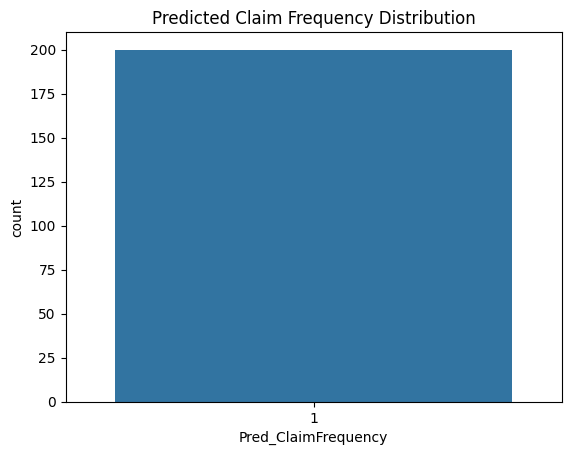

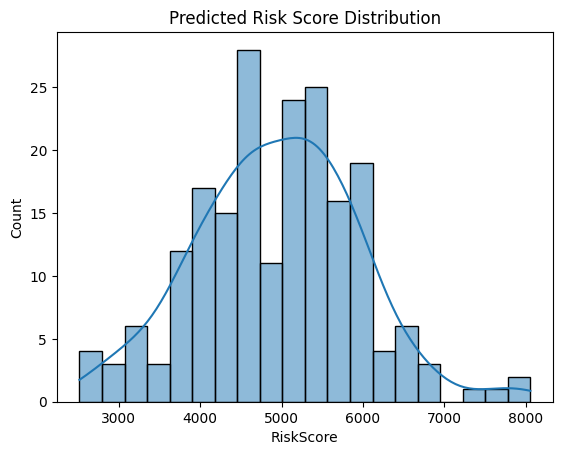

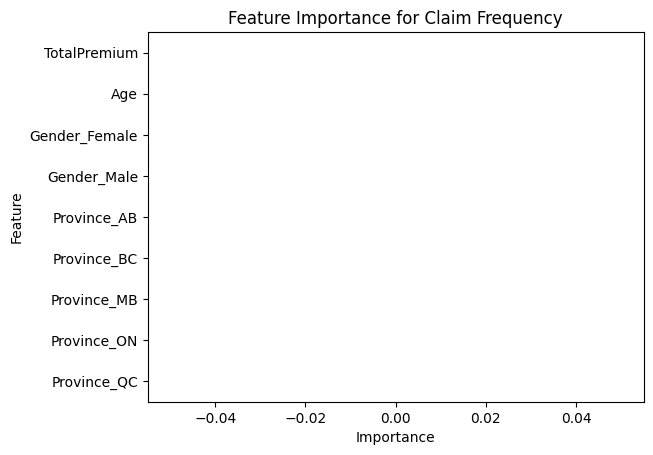

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of predicted claim frequency
sns.countplot(x='Pred_ClaimFrequency', data=df_pred)
plt.title("Predicted Claim Frequency Distribution")
plt.show()

# Distribution of risk scores
sns.histplot(df_pred['RiskScore'], bins=20, kde=True)
plt.title("Predicted Risk Score Distribution")
plt.show()

# Top features importance plot
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance for Claim Frequency")
plt.show()


Columns in dataset: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60


=== Classification: Claim Frequency ===
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_22520\1483119591.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ClaimSeverity'].fillna(0, inplace=True)



=== Regression: Claim Severity ===
RMSE: 3253.745952283425

Feature Importance:


,Feature,Importance
0,TotalPremium,0.0
1,Age,0.0
2,Gender_Female,0.0
3,Gender_Male,0.0
4,Province_AB,0.0
5,Province_BC,0.0
6,Province_MB,0.0
7,Province_ON,0.0
8,Province_QC,0.0



Predictions saved to ..\results\task4_predictions.csv

Top 10 High-Risk Policies:


,TotalPremium,Age,Gender,Province,Pred_ClaimFrequency,Pred_ClaimSeverity,RiskScore,RiskScore_Normalized
978,1995.97,39,Male,MB,1,8057.4000,8057.4000,1.000000
265,1937.95,43,Female,AB,1,7838.2492,7838.2492,0.960460
865,1945.71,61,Female,ON,1,7768.1984,7768.1984,0.947821
678,315.39,34,Female,MB,1,7415.4486,7415.4486,0.884176
213,1629.10,41,Male,AB,1,6858.7488,6858.7488,0.783733
578,320.67,19,Male,ON,1,6848.5715,6848.5715,0.781897
595,396.20,67,Male,ON,1,6681.3435,6681.3435,0.751725
528,1764.87,56,Male,ON,1,6636.2612,6636.2612,0.743591
254,944.46,65,Male,AB,1,6579.5483,6579.5483,0.733358
714,1215.16,36,Female,AB,1,6536.0782,6536.0782,0.725515



Risk scores saved to ..\results\task4_risk_scores.csv


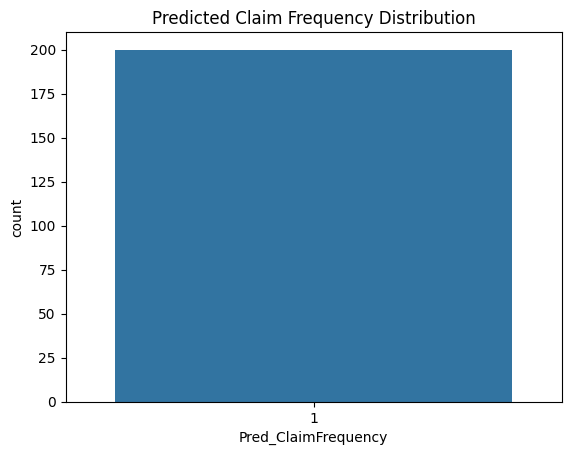

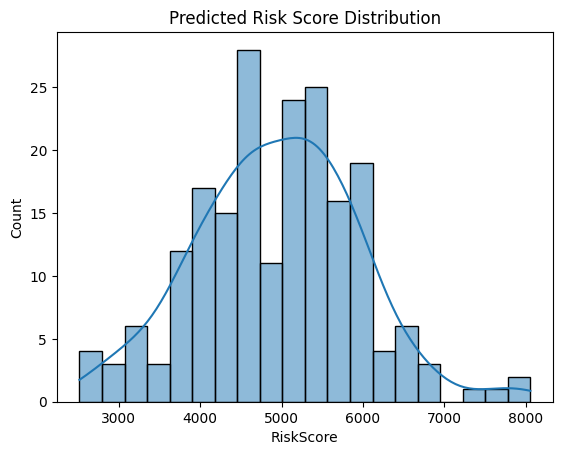

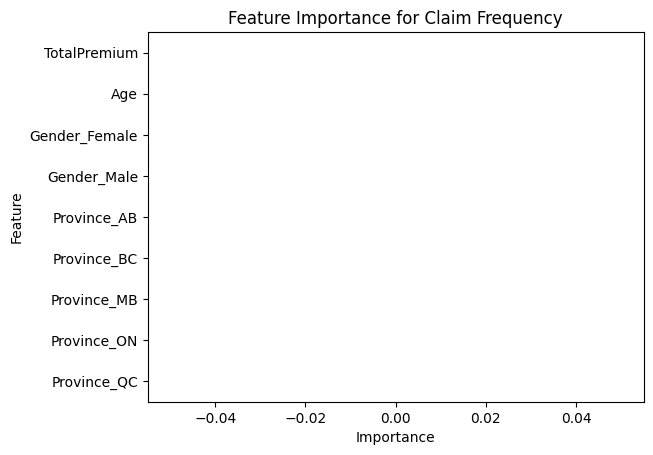


--- Business Interpretation ---
High-risk policies have high RiskScore.
Feature importance shows key drivers of claim frequency.
Use insights to adjust premiums or risk mitigation strategies.


In [11]:
# ===========================
# Task 4: Predictive Modeling & Risk Scoring
# ===========================

# ===========================
# Step 0: Import Libraries
# ===========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

pd.set_option('display.max_columns', None)

# ===========================
# Step 1: Load Data
# ===========================
data_path = os.path.join('..', 'data', 'insurance_data.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found at {data_path}. Please check your path!")

df = pd.read_csv(data_path)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# ===========================
# Step 2: Define Targets
# ===========================
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)
df['ClaimSeverity'] = df['TotalClaims'] / df['ClaimFrequency'].replace(0, np.nan)
df['ClaimSeverity'].fillna(0, inplace=True)

# ===========================
# Step 3: Feature Selection
# ===========================
features = ['TotalPremium', 'Age', 'Gender', 'Province']
target_class = 'ClaimFrequency'
target_reg = 'ClaimSeverity'

df = df.dropna(subset=features + [target_class, target_reg])

# ===========================
# Step 4: Preprocessing Pipeline
# ===========================
categorical_features = ['Gender', 'Province']
numerical_features = ['TotalPremium', 'Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# ===========================
# Step 5: Train-Test Split
# ===========================
X = df[features]
y_class = df[target_class]
y_reg = df[target_reg]

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# ===========================
# Step 6a: Classification Model
# ===========================
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("=== Classification: Claim Frequency ===")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))

# ===========================
# Step 6b: Regression Model
# ===========================
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

reg.fit(X_train_r, y_train_reg)
y_pred_reg = reg.predict(X_test_r)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("\n=== Regression: Claim Severity ===")
print("RMSE:", rmse)

# ===========================
# Step 7: Feature Importance (Classification)
# ===========================
feature_names = numerical_features + list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importances = clf.named_steps['classifier'].feature_importances_

feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
display(feat_importance)

# ===========================
# Step 8: Save Predictions
# ===========================
df_pred = X_test.copy()
df_pred['Pred_ClaimFrequency'] = y_pred_class
df_pred['Pred_ClaimSeverity'] = y_pred_reg

results_path = os.path.join('..', 'results', 'task4_predictions.csv')
os.makedirs(os.path.dirname(results_path), exist_ok=True)
df_pred.to_csv(results_path, index=False)
print(f"\nPredictions saved to {results_path}")

# ===========================
# Step 9: Risk Scoring
# ===========================
df_pred['RiskScore'] = df_pred['Pred_ClaimFrequency'] * df_pred['Pred_ClaimSeverity']
df_pred['RiskScore_Normalized'] = (df_pred['RiskScore'] - df_pred['RiskScore'].min()) / \
                                   (df_pred['RiskScore'].max() - df_pred['RiskScore'].min())

print("\nTop 10 High-Risk Policies:")
display(df_pred.sort_values(by='RiskScore', ascending=False).head(10))

# Save risk scores
risk_path = os.path.join('..', 'results', 'task4_risk_scores.csv')
df_pred.to_csv(risk_path, index=False)
print(f"\nRisk scores saved to {risk_path}")

# ===========================
# Step 10: Visualizations
# ===========================
sns.countplot(x='Pred_ClaimFrequency', data=df_pred)
plt.title("Predicted Claim Frequency Distribution")
plt.show()

sns.histplot(df_pred['RiskScore'], bins=20, kde=True)
plt.title("Predicted Risk Score Distribution")
plt.show()

sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance for Claim Frequency")
plt.show()

# ===========================
# Step 11: Business Interpretation
# ===========================
print("\n--- Business Interpretation ---")
print("High-risk policies have high RiskScore.")
print("Feature importance shows key drivers of claim frequency.")
print("Use insights to adjust premiums or risk mitigation strategies.")
